In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from packaging import version
from tensorflow.keras import layers, models, backend as k
import seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error as MSE, confusion_matrix
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
import tensorflow_datasets as tfds
import re
import string
import time

In [ ]:
nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")

In [ ]:
# Load the dataset
dataset_all, info = tfds.load('ag_news_subset', with_info=True, split='train+test', as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.MGR9U8_1.0.0/ag_news_subset-train.tfrecord*...: …

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.MGR9U8_1.0.0/ag_news_subset-test.tfrecord*...:  …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Define custom stopwords function
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*', '')

# Text vectorization and adaptation function
def text_vectorization_and_adapt(text_dataset, max_tokens=None, standardize_fn=None, output_sequence_length=None):
    text_vectorization = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        standardize=standardize_fn,
        output_sequence_length=output_sequence_length
    )
    text_vectorization.adapt(text_dataset)
    return text_vectorization

In [ ]:
# Define fully-connected models with different hyperparameters
def create_fully_connected_model_1(vocab_size, output_sequence_length):
    k.clear_session()
    inputs = tf.keras.Input(shape=(output_sequence_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=output_sequence_length)(inputs)
    x = layers.GlobalAveragePooling1D()(embedded)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

def create_fully_connected_model_2(vocab_size, output_sequence_length):
    k.clear_session()
    inputs = tf.keras.Input(shape=(output_sequence_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=output_sequence_length)(inputs)
    x = layers.GlobalAveragePooling1D()(embedded)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

def create_fully_connected_model_3(vocab_size, output_sequence_length):
    k.clear_session()
    inputs = tf.keras.Input(shape=(output_sequence_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=output_sequence_length)(inputs)
    x = layers.GlobalAveragePooling1D()(embedded)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [ ]:

# Function to train and evaluate the model
def train_and_evaluate_fully_connected_model(vocab_size, text_vectorization, output_sequence_length, model_name, create_model_fn):
    # Print the name of the experiment
    print(f"Starting experiment: {model_name} with vocab size {vocab_size}")

    # Prepare the dataset
    def vectorize_text(text, label):
        text = text_vectorization(text)
        return text, label

    vectorized_dataset = dataset_all.map(vectorize_text)
    vectorized_dataset = vectorized_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    # Split the dataset
    dataset_size = len(list(vectorized_dataset))
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size

    train_dataset = vectorized_dataset.take(train_size).batch(32)
    val_dataset = vectorized_dataset.skip(train_size).take(val_size).batch(32)

    # Train the model
    model = create_model_fn(vocab_size, output_sequence_length)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(f"{model_name}.h5", save_best_only=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
    start_time = time.time()
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=200, callbacks=callbacks)
    training_time = time.time() - start_time

    # Evaluate on validation dataset
    val_loss, val_accuracy = model.evaluate(val_dataset)

    # Load the best model and evaluate on validation dataset
    model = models.load_model(f"{model_name}.h5")
    test_loss, test_accuracy = model.evaluate(val_dataset)

    # Collect final train accuracy and loss
    train_acc = history.history['accuracy'][-1]
    train_loss = history.history['loss'][-1]

    return {
        'model_name': model_name,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'train_time': training_time,
        'val_acc': val_accuracy,
        'val_loss': val_loss,
        'test_acc': test_accuracy,
        'test_loss': test_loss,
        'history': history
    }

In [ ]:
# Experiments with different fully-connected models
experiments = [
    {"name": "fully_connected_model_1", "create_model_fn": create_fully_connected_model_1, "vocab_size": 20000},
    {"name": "fully_connected_model_2", "create_model_fn": create_fully_connected_model_2, "vocab_size": 20000},
    {"name": "fully_connected_model_3", "create_model_fn": create_fully_connected_model_3, "vocab_size": 20000}
]


In [ ]:
all_results_fully_connected = []
for experiment in experiments:
    try:
        text_vectorization = text_vectorization_and_adapt(
            dataset_all.map(lambda text, label: text),
            max_tokens=experiment["vocab_size"],
            standardize_fn=custom_stopwords,
            output_sequence_length=100
        )
        results = train_and_evaluate_fully_connected_model(experiment["vocab_size"], text_vectorization, 100, experiment["name"], experiment["create_model_fn"])
        all_results_fully_connected.append(results)
    except ValueError as e:
        print(f"Error with vocab_size {experiment['vocab_size']}: {e}")


Starting experiment: fully_connected_model_1 with vocab size 20000
Epoch 1/200
3190/3190 [==============================] - 260s 81ms/step - loss: 0.4676 - accuracy: 0.8415 - val_loss: 0.2796 - val_accuracy: 0.9077


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
3190/3190 [==============================] - 250s 78ms/step - loss: 0.2549 - accuracy: 0.9187 - val_loss: 0.2721 - val_accuracy: 0.9094
Epoch 3/200
3190/3190 [==============================] - 249s 78ms/step - loss: 0.2038 - accuracy: 0.9324 - val_loss: 0.2909 - val_accuracy: 0.9077
Epoch 4/200
3190/3190 [==============================] - 255s 80ms/step - loss: 0.1701 - accuracy: 0.9415 - val_loss: 0.3202 - val_accuracy: 0.9053
Epoch 5/200
798/798 [==============================] - 4s 4ms/step - loss: 0.2721 - accuracy: 0.9094
Starting experiment: fully_connected_model_2 with vocab size 20000
Epoch 1/200
3190/3190 [==============================] - 259s 81ms/step - loss: 0.4089 - accuracy: 0.8599 - val_loss: 0.2729 - val_accuracy: 0.9078
Epoch 2/200
3190/3190 [==============================] - 259s 81ms/step - loss: 0.2237 - accuracy: 0.9241 - val_loss: 0.2706 - val_accuracy: 0.9094
Epoch 3/200
3190/3190 [==============================] - 251s 79ms/step - loss: 0.1742 - acc

In [ ]:
# Create a DataFrame to display the results
df_fully_connected = pd.DataFrame(all_results_fully_connected)

# Adjust display settings for better alignment
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Display the DataFrame
print(df_fully_connected)

                model_name  train_acc  train_loss   train_time   val_acc  val_loss  test_acc  test_loss                                            history
0  fully_connected_model_1   0.948687    0.144792  1271.752250  0.901215  0.367447  0.909444   0.272050  <keras.src.callbacks.History object at 0x7b5b9...
1  fully_connected_model_2   0.958160    0.114728  1233.423407  0.894279  0.412448  0.909365   0.270625  <keras.src.callbacks.History object at 0x7b5b8...
2  fully_connected_model_3   0.950255    0.130944  1264.835693  0.895886  0.452296  0.907132   0.280863  <keras.src.callbacks.History object at 0x7b5b7...


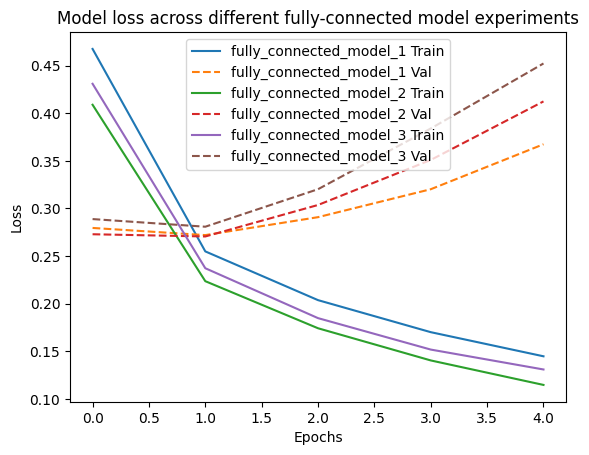

In [ ]:
# Plot loss vs epochs for different fully-connected models
for result in all_results_fully_connected:
    history = result['history']
    model_name = result['model_name']
    plt.plot(history.history['loss'], label=f'{model_name} Train')
    plt.plot(history.history['val_loss'], label=f'{model_name} Val', linestyle='--')

plt.title("Model loss across different fully-connected model experiments")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/458_M6_A3_fully_conn.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/458_M6_A3_fully_conn.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 423, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 560, in convert_single_notebook
    output, resources = self.export_single_notebook(
  File "/usr/local/lib/python3.10/dist-p